# CMIP6 SSP2-4.5 and SSP5-8.5

Extract the datasets, regrid them, calculate multimodel means, checkout means of the end of the century vs 20th century.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import xarray as xr
import xesmf as xe
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:34709 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 250.00 GiB


In [16]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

def circumpolar_map(*, land = True):
    
    fig = plt.figure(figsize = (28, 10))
    axs = [fig.add_subplot(221, projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(222, projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(223, projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(224, projection = ccrs.Mercator(central_longitude = 200))]
    for ax in axs:
        ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
        if land:
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                           edgecolor = 'black', facecolor = 'white'))
        else:
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                           edgecolor = 'black', facecolor = 'none'))
        ax.set_xticks(np.arange(-150, 200, 50), crs = ccrs.PlateCarree())
        ax.set_yticks([-75, -70, -65, -60, -55], crs = ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label = False)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
    
    return fig, axs

def extract_so(ds):
    ds_so = ds.sel(lat = slice(None, -50))
    return ds_so

def multimodel_map():
    
    fig = plt.figure(figsize = (30, 27))
    gr = gs.GridSpec(5, 5, figure = fig, height_ratios = [1, 1, 1, 1, .1]); axs = []
    for i in range(4):
        for j in range(5):
            axs.append(fig.add_subplot(gr[i,j], projection = ccrs.SouthPolarStereo()))
    axs.append(fig.add_subplot(gr[4,1:-1]))
    for ax in axs[:-1]:
        ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)
    
    return fig, axs

def southern_ocean_plot():
    fig = plt.figure(1, figsize = (16, 12))
    ax1 = fig.add_axes([0.0, 0.5, 0.5, 0.5], projection = ccrs.SouthPolarStereo())
    ax1.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform = ax1.transAxes)
    
    ax2 = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection = ccrs.SouthPolarStereo())
    ax2.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax2.set_boundary(circle, transform = ax2.transAxes)
    
    ax3 = fig.add_axes([0.3, 0.43, 0.3, 0.02])
    plt.tight_layout()
    return fig, [ax1, ax2, ax3]

# Get CMIP6 SSP2-4.5 and SSP5-8.5 projections, surface winds

Save original grid, and the regridded dataset to calculate ensmean using cdo

In [140]:
ssp2_paths = ! clef --local cmip6 -v uas -t Amon -e ssp245 
paths_u = []
for path in ssp2_paths:
    if 'r1i1p1f1' in path:
        print(path)
        paths_u.append(path)

ssp2_paths = ! clef --local cmip6 -v vas -t Amon -e ssp245 
paths_v = []
for path in ssp2_paths:
    if 'r1i1p1f1' in path:
        print(path)
        paths_v.append(path)

/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp245/r1i1p1f1/Amon/uas/gn/v20191108
/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp245/r1i1p1f1/Amon/uas/gn/v20191115
/g/data/oi10/replicas/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR/ssp245/r1i1p1f1/Amon/uas/gn/v20190529
/g/data/oi10/replicas/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp245/r1i1p1f1/Amon/uas/gn/v20190314
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp245/r1i1p1f1/Amon/uas/gn/v20190708
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp245/r1i1p1f1/Amon/uas/gr/v20191013
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CCCR-IITM/IITM-ESM/ssp245/r1i1p1f1/Amon/uas/gn/v20200915
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp245/r1i1p1f1/Amon/uas/gn/v20190306
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp245/r1i1p1f1/Amon/uas/gn/v20190429
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp245/r1i1p1f1/Amon/uas/gn/v20200617
/g/data/oi10/replicas/CMIP6/Scenario

In [144]:
time_dim = xr.open_mfdataset(paths_u[0]+'/*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))['time'].values
time_dim

array(['2015-01-16T12:00:00.000000000', '2015-02-15T00:00:00.000000000',
       '2015-03-16T12:00:00.000000000', ...,
       '2099-10-16T12:00:00.000000000', '2099-11-16T00:00:00.000000000',
       '2099-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [145]:
for p in paths_u:
    uas = xr.open_mfdataset(p+'/*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    name = p.split('/')[-7]
    uas['time'] = time_dim
    uas.to_netcdf('/scratch/e14/jn8053/cmip6/ssp4.5/uas/uas-ssp4.5-2015_2100-'+name+'.nc')

In [146]:
jra = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/ssp4.5/uas/*')
for i in range(len(path_uas)):
    
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]

    ds = xr.open_dataset(path_uas[i])
    ds_in = ds['uas'].to_dataset()
    ds_out = jra['uas'].to_dataset()
    
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    dr_out.to_netcdf('/scratch/e14/jn8053/cmip6/ssp4.5/uas-regrid/uas_ssp4.5_'+model_name+'.nc')

In [159]:
for p in paths_v:
    vas = xr.open_mfdataset(p+'/*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    name = p.split('/')[-7]
    vas['time'] = time_dim
    vas.to_netcdf('/scratch/e14/jn8053/cmip6/ssp4.5/vas/vas-ssp4.5-2015_2100-'+name+'.nc')

In [160]:
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/ssp4.5/vas/*')
for i in range(len(path_vas)):
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]

    ds = xr.open_dataset(path_vas[i])
    ds_in = ds['vas'].to_dataset()
    ds_out = jra['uas'].to_dataset()
    
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    dr_out.to_netcdf('/scratch/e14/jn8053/cmip6/ssp4.5/vas-regrid/vas_ssp4.5_'+model_name+'.nc')

In [169]:
ssp8_paths = ! clef --local cmip6 -v uas -t Amon -e ssp585
paths_u = []
for path in ssp8_paths:
    if 'r1i1p1f1' in path:
        print(path)
        paths_u.append(path)
# Remove duplicate versions
paths_u.remove('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/uas/gn/v20191108')
paths_u.remove('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Amon/uas/gn/v20191115')
paths_u.remove('/g/data/oi10/replicas/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Amon/uas/gr/v20190629')
paths_u.remove('/g/data/oi10/replicas/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp585/r1i1p1f1/Amon/uas/gr1/v20191106')
ssp8_paths = ! clef --local cmip6 -v vas -t Amon -e ssp585
paths_v = []
for path in ssp8_paths:
    if 'r1i1p1f1' in path:
        print(path)
        paths_v.append(path)
# Remove duplicate versions
paths_v.remove('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/vas/gn/v20191108')
paths_v.remove('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Amon/vas/gn/v20191115')
paths_v.remove('/g/data/oi10/replicas/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp585/r1i1p1f1/Amon/vas/gr1/v20191106')

/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/uas/gn/v20191108
/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/uas/gn/v20210317
/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Amon/uas/gn/v20191115
/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Amon/uas/gn/v20210318
/g/data/oi10/replicas/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR/ssp585/r1i1p1f1/Amon/uas/gn/v20190529
/g/data/oi10/replicas/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/uas/gn/v20190314
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp585/r1i1p1f1/Amon/uas/gn/v20190708
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp585/r1i1p1f1/Amon/uas/gr/v20191013
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CCCR-IITM/IITM-ESM/ssp585/r1i1p1f1/Amon/uas/gn/v20200915
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Amon/uas/gn/v20190306
/g/data/oi10/rep

In [174]:
for p in paths_u:
    n_files = len(os.listdir(p))
    if n_files == 2:
        uas = xr.open_mfdataset(p+'/*201501-210012*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    elif n_files == 1:
        uas = xr.open_mfdataset(p+'/*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    else:
        uas = xr.open_mfdataset(p+'/*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    name = p.split('/')[-7]
    uas['time'] = time_dim
    #print(name + ' '+ str(uas['time.year'][0].values) + ' '+ str(uas['time.year'][-1].values))
    uas.to_netcdf('/scratch/e14/jn8053/cmip6/ssp8.5/uas/uas-ssp8.5-2015_2100-'+name+'.nc')

In [175]:
jra = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/uas/*')
for i in range(len(path_uas)):
    
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]

    ds = xr.open_dataset(path_uas[i])
    ds_in = ds['uas'].to_dataset()
    ds_out = jra['uas'].to_dataset()
    
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    dr_out.to_netcdf('/scratch/e14/jn8053/cmip6/ssp8.5/uas-regrid/uas_ssp8.5_'+model_name+'.nc')

In [184]:
for p in paths_v:
    n_files = len(os.listdir(p))
    if n_files == 2:
        vas = xr.open_mfdataset(p+'/*201501-210012*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    elif n_files == 1:
        vas = xr.open_mfdataset(p+'/*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    else:
        vas = xr.open_mfdataset(p+'/*.nc', concat_dim = 'time').sel(lat = slice(None, -50)).isel(time = slice(None, 1020))
    name = p.split('/')[-7]
    vas['time'] = time_dim
    vas.to_netcdf('/scratch/e14/jn8053/cmip6/ssp8.5/vas/vas-ssp8.5-2015_2100-'+name+'.nc')

In [187]:
jra = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/vas/*')
for i in range(len(path_vas)):
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]

    ds = xr.open_dataset(path_vas[i])
    ds_in = ds['vas'].to_dataset()
    ds_out = jra['uas'].to_dataset()
    
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    dr_out.to_netcdf('/scratch/e14/jn8053/cmip6/ssp8.5/vas-regrid/vas_ssp8.5_'+model_name+'.nc')

# Final vs baseline periods, multimodel mean

In [3]:
uas = {}; vas = {}
names = []
# Load baseline period 
uas['hist', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-monthly-1958_2015.nc').sel(time = slice(None, '1978-01-01')).mean('time')
vas['hist', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-monthly-1958_2015.nc').sel(time = slice(None, '1978-01-01')).mean('time')
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas['hist', model_name] = xr.open_dataset(path_uas[i]).sel(time = slice(None, '1978-01-01')).mean('time')
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas['hist', model_name] = xr.open_dataset(path_vas[i]).sel(time = slice(None, '1978-01-01')).mean('time')
    names.append(model_name)
    
# Load projections period
uas['ssp4', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp4.5/uas-ssp4.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).mean('time')
vas['ssp4', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp4.5/vas-ssp4.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).mean('time')
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/ssp4.5/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/ssp4.5/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas['ssp4', model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('2081-01-01', None)).mean('time')
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas['ssp4', model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('2081-01-01', None)).mean('time')
    
uas['ssp8', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp8.5/uas-ssp8.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).mean('time')
vas['ssp8', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp8.5/vas-ssp8.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).mean('time')
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas['ssp8', model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('2081-01-01', None)).mean('time')
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas['ssp8', model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('2081-01-01', None)).mean('time')

In [4]:
mask_file = np.load('/g/data/e14/hd4873/runs/parcels/input/proj01/Antarctic_slope_contour_ht_1000m.npz')
shelf_mask = mask_file['contour_masked_above']
xt_ocean = mask_file['xt_ocean']
yt_ocean = mask_file['yt_ocean']
shelf_mask[shelf_mask != 0] = np.nan
shelf_mask[shelf_mask == 0] = 1
shelf_mask = xr.DataArray(shelf_mask, dims = ['yt_ocean', 'xt_ocean'], coords = {'yt_ocean':yt_ocean, 'xt_ocean':xt_ocean})
mask = change_lon_space(shelf_mask, 't')
mask = mask.interp(lon = uas['hist', 'CMIP6']['lon'], lat = uas['hist', 'CMIP6']['lat'])

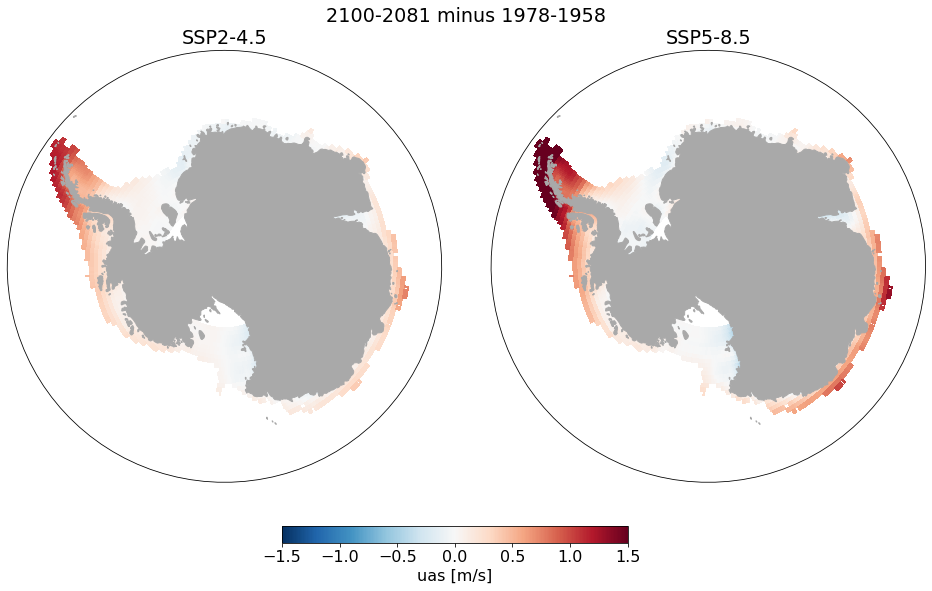

In [5]:
fig, axs = southern_ocean_plot()
c = axs[0].pcolormesh(uas['ssp4', 'CMIP6']['lon'], uas['ssp4', 'CMIP6']['lat'], (uas['ssp4', 'CMIP6']['uas']-uas['hist', 'CMIP6']['uas'])*mask, 
                      vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
c = axs[1].pcolormesh(uas['ssp4', 'CMIP6']['lon'], uas['ssp4', 'CMIP6']['lat'], (uas['ssp8', 'CMIP6']['uas']-uas['hist', 'CMIP6']['uas'])*mask, 
                      vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].set_title('SSP2-4.5')
axs[1].set_title('SSP5-8.5')
plt.suptitle('2100-2081 minus 1978-1958', x = 0.46, y = 1.05)
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('uas [m/s]')
plt.savefig(figdir+'/easterlies-collaborative/cmip6/projections/uas-cmip6-ssps_historical.png', facecolor = 'white', bbox_inches = 'tight')

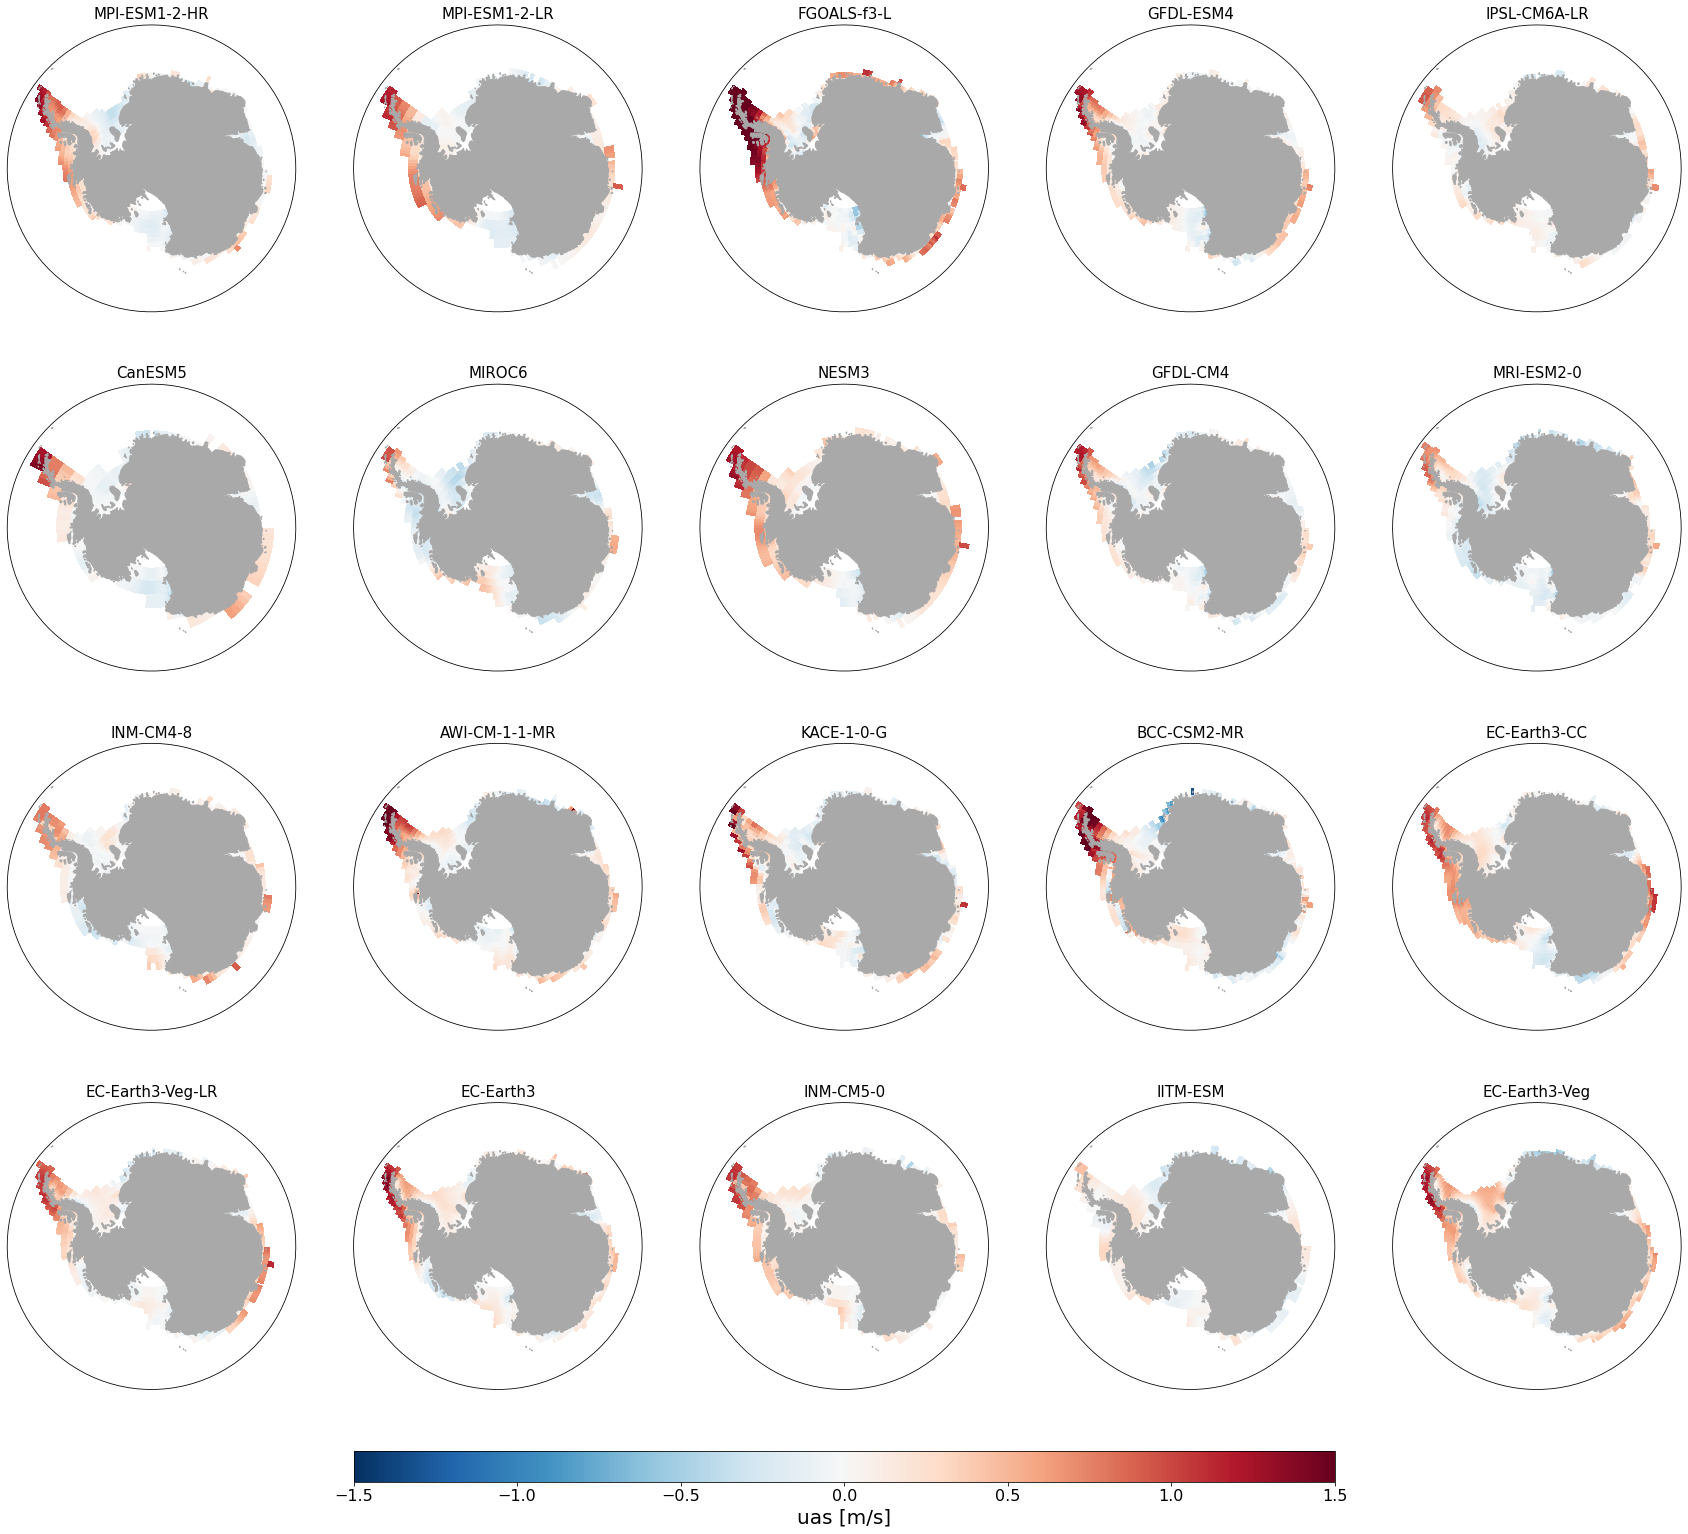

In [17]:
fig, axs = multimodel_map()
n = 0
for name in names:
    m = mask.interp(lon = uas['ssp4', name]['lon'], lat = uas['ssp4', name]['lat'])
    c = axs[n].pcolormesh(uas['ssp4', name]['lon'], uas['ssp4', name]['lat'], (uas['ssp4', name]['uas']-uas['hist', name]['uas'])*m, 
                          vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
    axs[n].set_title(name, fontsize = 15); n+=1
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('uas [m/s]', fontsize = 20)
plt.tight_layout()
plt.savefig(figdir+'/easterlies-collaborative/cmip6/projections/uas-cmip6ind-ssp4.5_historical.png', facecolor = 'white', bbox_inches = 'tight')

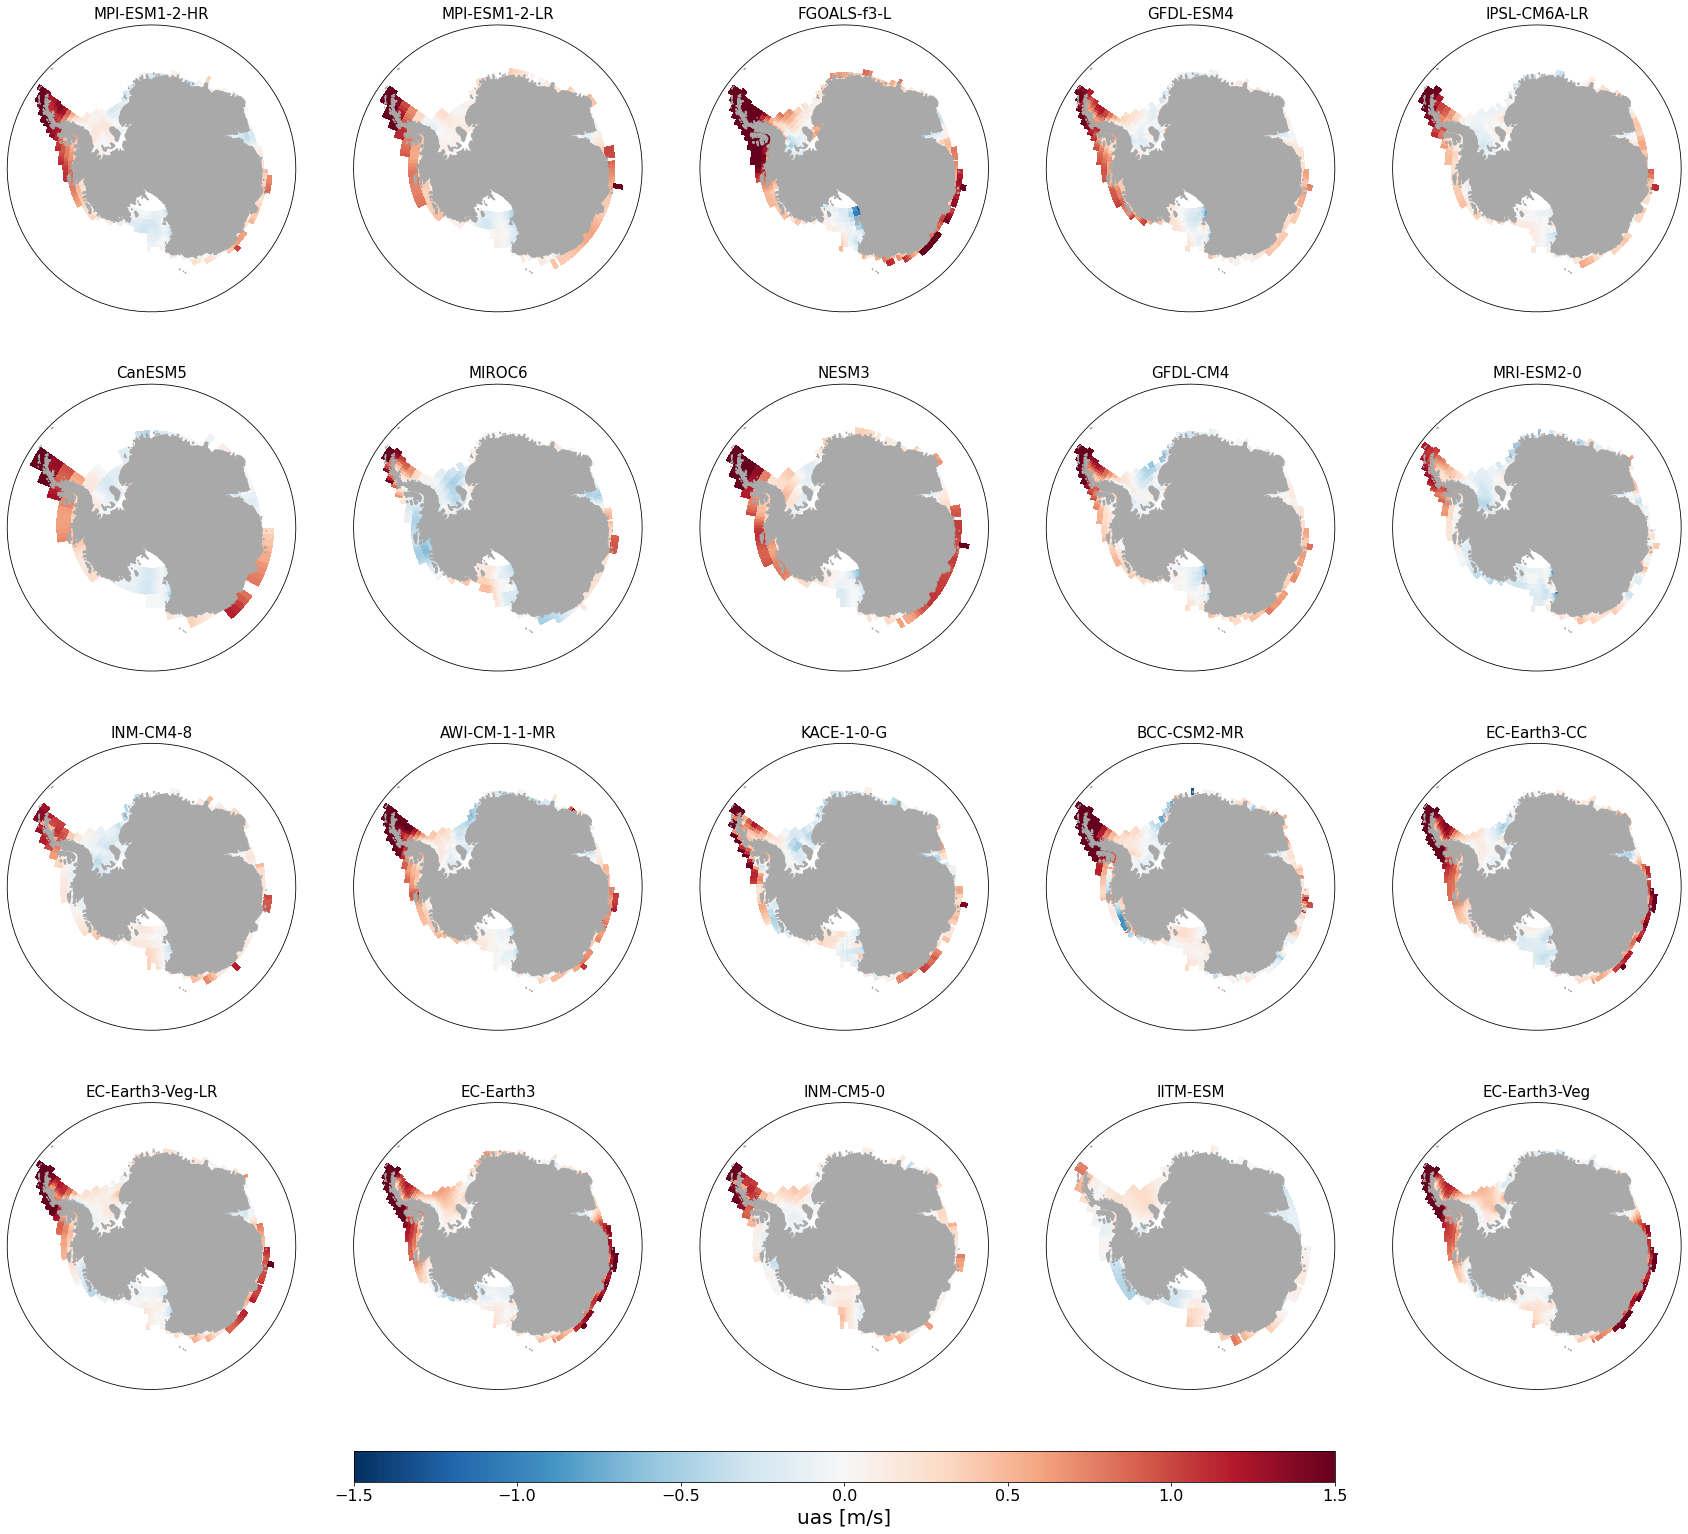

In [18]:
fig, axs = multimodel_map()
n = 0
for name in names:
    m = mask.interp(lon = uas['ssp8', name]['lon'], lat = uas['ssp8', name]['lat'])
    c = axs[n].pcolormesh(uas['ssp8', name]['lon'], uas['ssp8', name]['lat'], (uas['ssp8', name]['uas']-uas['hist', name]['uas'])*m, 
                          vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
    axs[n].set_title(name, fontsize = 15); n+=1
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('uas [m/s]', fontsize = 20)
plt.tight_layout()
plt.savefig(figdir+'/easterlies-collaborative/cmip6/projections/uas-cmip6ind-ssp8.5_historical.png', facecolor = 'white', bbox_inches = 'tight')

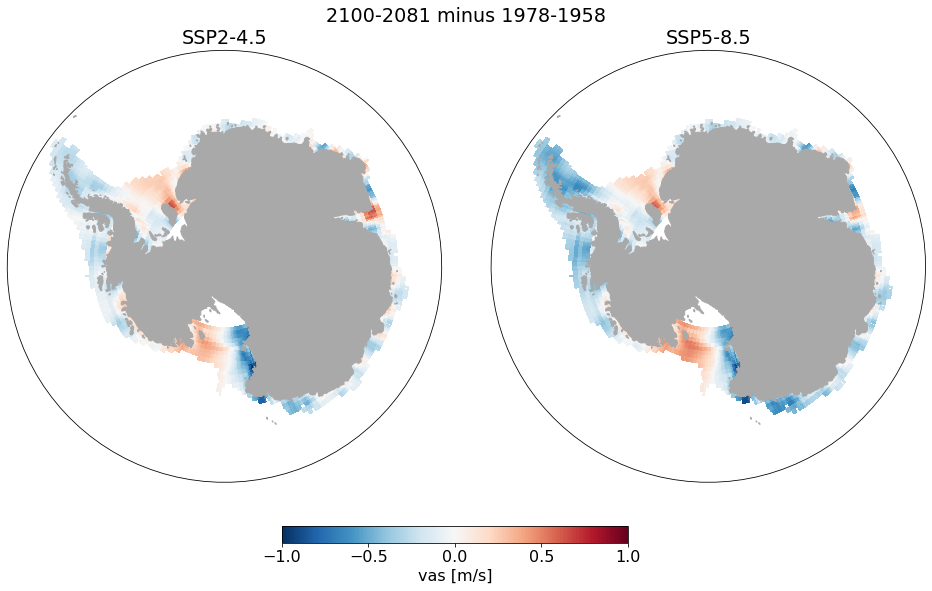

In [11]:
fig, axs = southern_ocean_plot()
c = axs[0].pcolormesh(vas['ssp4', 'CMIP6']['lon'], vas['ssp4', 'CMIP6']['lat'], (vas['ssp4', 'CMIP6']['vas']-vas['hist', 'CMIP6']['vas'])*mask, 
                      vmin = -1, vmax = 1, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
c = axs[1].pcolormesh(vas['ssp4', 'CMIP6']['lon'], vas['ssp4', 'CMIP6']['lat'], (vas['ssp8', 'CMIP6']['vas']-vas['hist', 'CMIP6']['vas'])*mask, 
                      vmin = -1, vmax = 1, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].set_title('SSP2-4.5')
axs[1].set_title('SSP5-8.5')
plt.suptitle('2100-2081 minus 1978-1958', x = 0.46, y = 1.05)
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('vas [m/s]')
plt.savefig(figdir+'/easterlies-collaborative/cmip6/projections/vas-cmip6-ssps_historical.png', facecolor = 'white', bbox_inches = 'tight')

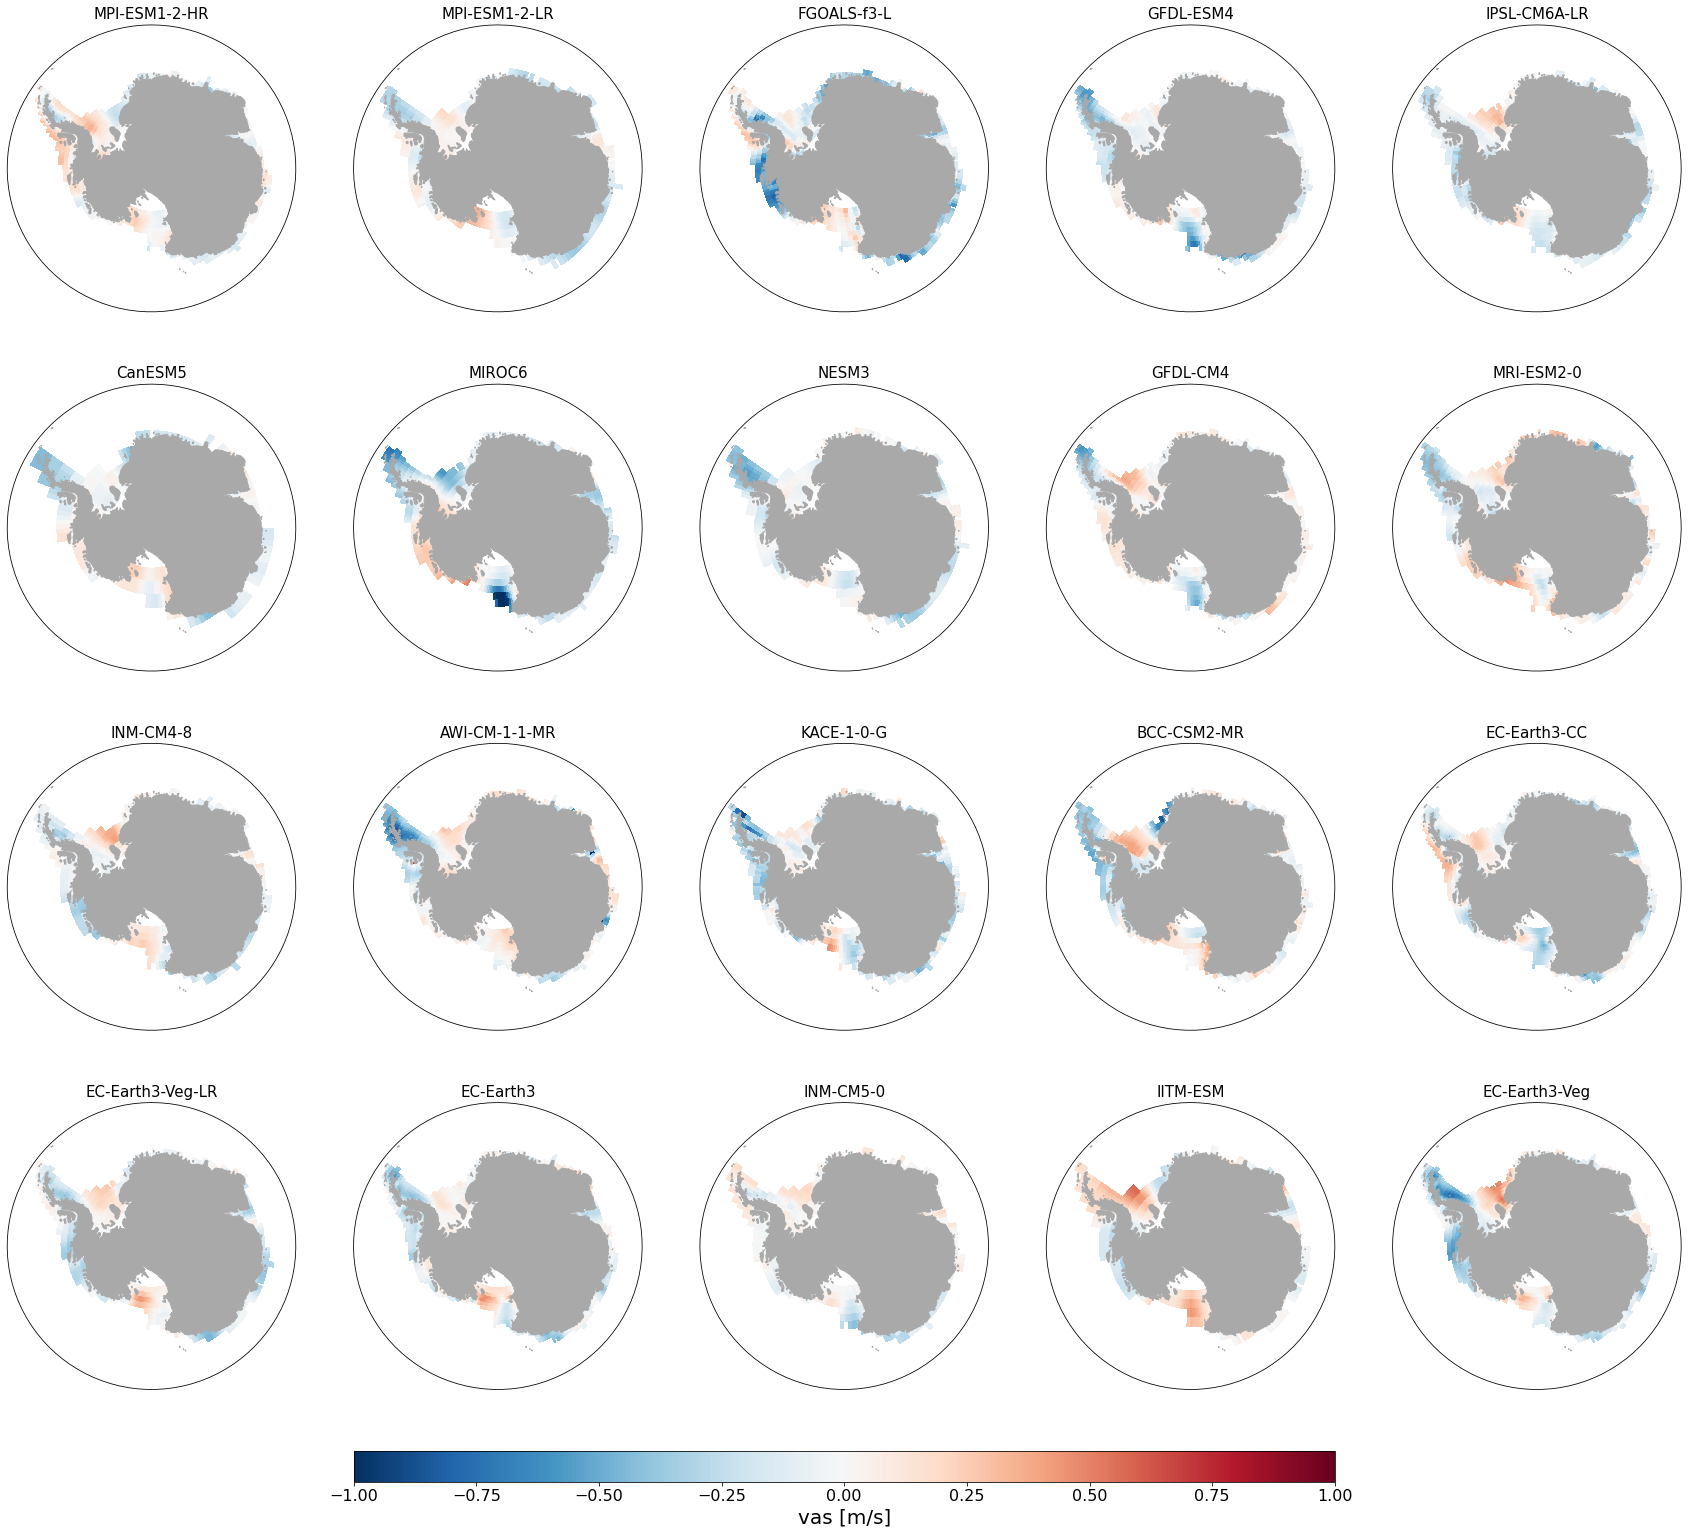

In [22]:
fig, axs = multimodel_map()
n = 0
for name in names:
    m = mask.interp(lon = vas['ssp4', name]['lon'], lat = vas['ssp4', name]['lat'])
    c = axs[n].pcolormesh(vas['ssp4', name]['lon'], vas['ssp4', name]['lat'], (vas['ssp4', name]['vas']-vas['hist', name]['vas'])*m, 
                          vmin = -1, vmax = 1, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
    axs[n].set_title(name, fontsize = 15); n+=1
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('vas [m/s]', fontsize = 20)
plt.tight_layout()
plt.savefig(figdir+'/easterlies-collaborative/cmip6/projections/vas-cmip6ind-ssp4.5_historical.png', facecolor = 'white', bbox_inches = 'tight')

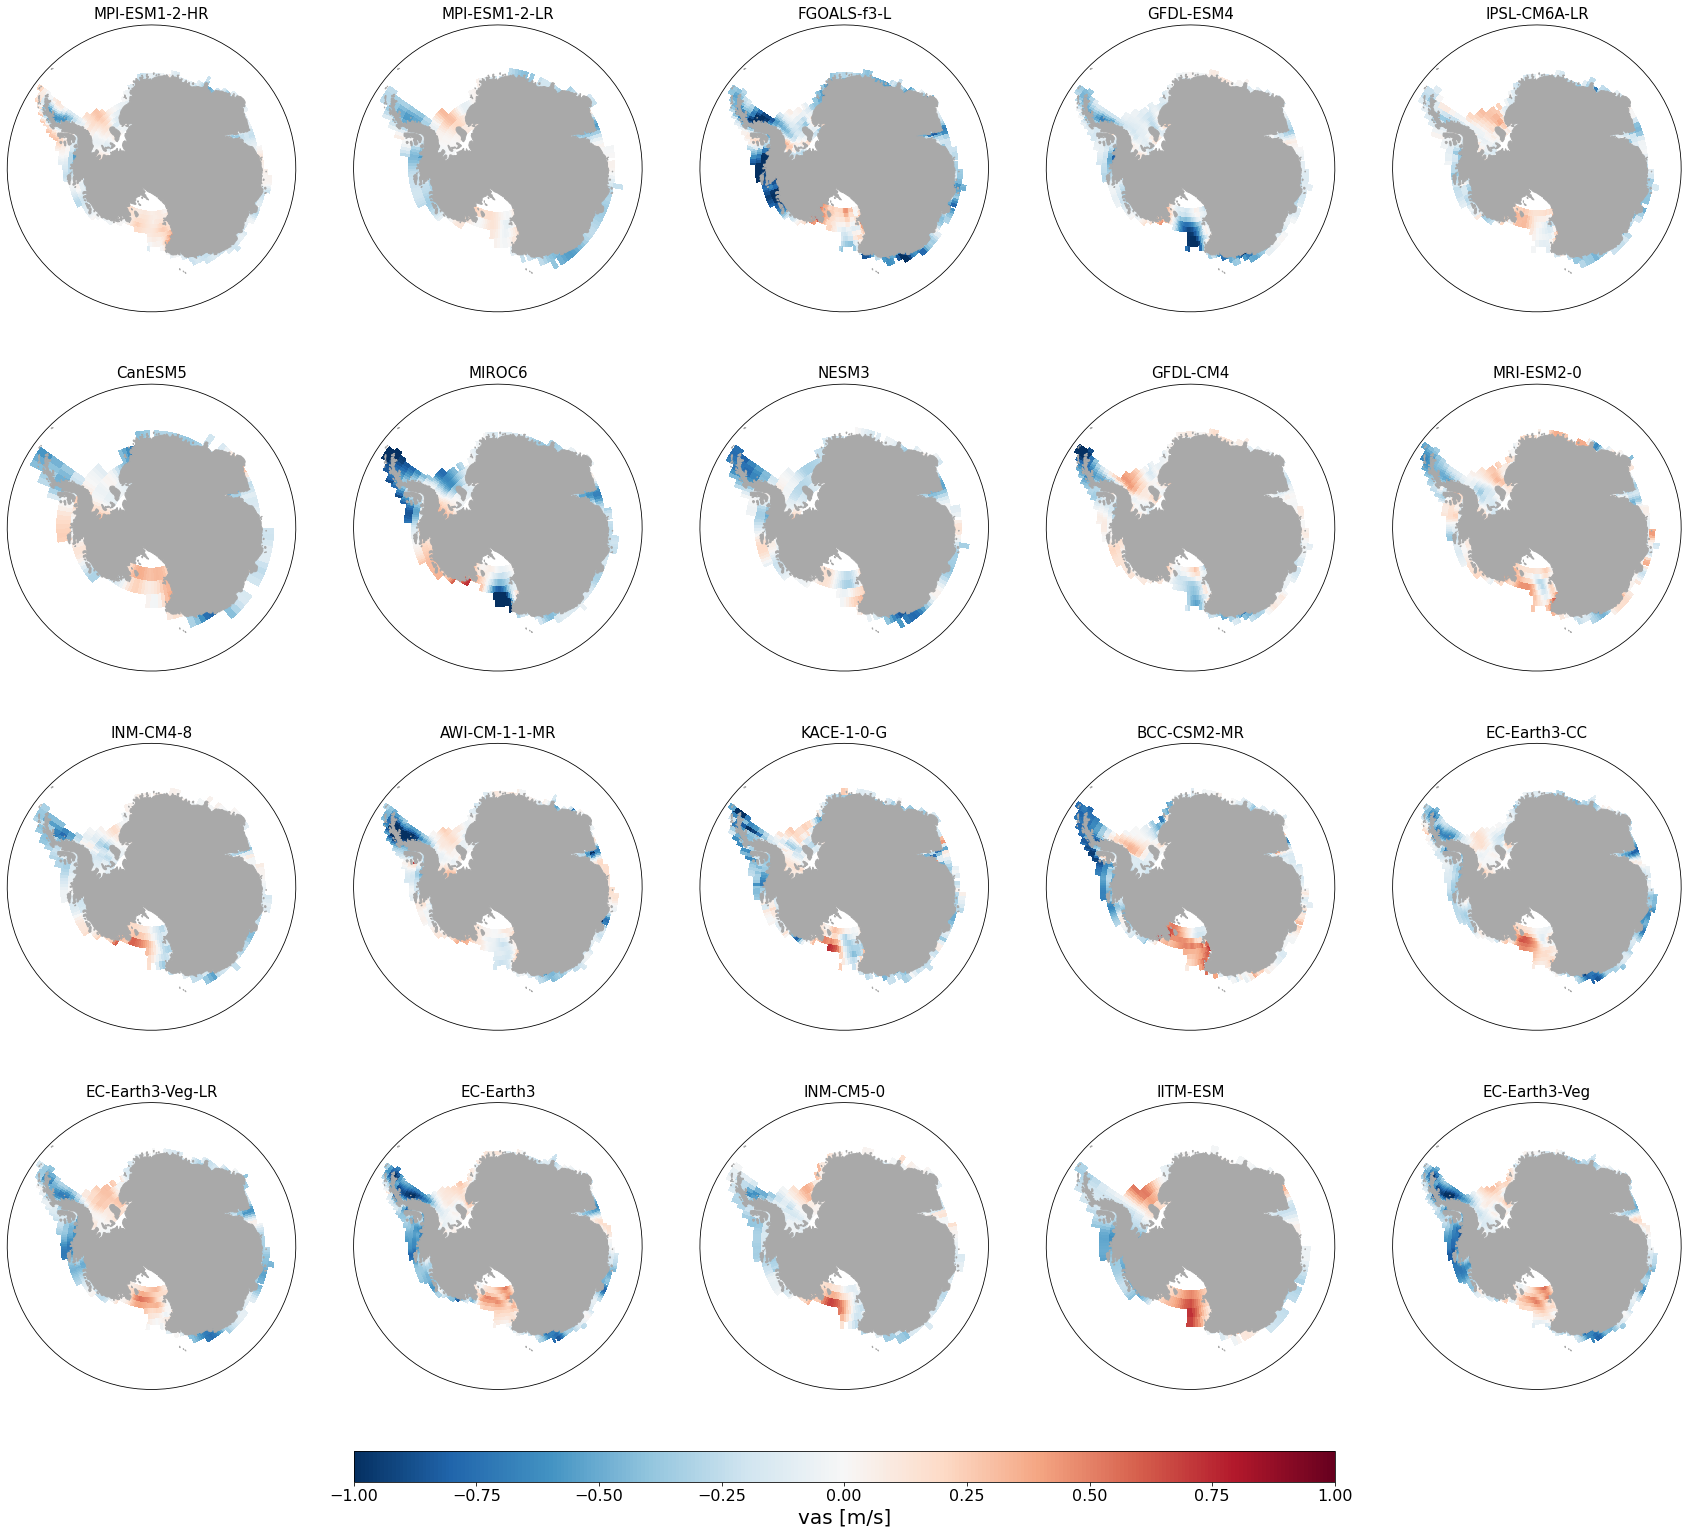

In [21]:
fig, axs = multimodel_map()
n = 0
for name in names:
    m = mask.interp(lon = vas['ssp8', name]['lon'], lat = vas['ssp8', name]['lat'])
    c = axs[n].pcolormesh(vas['ssp8', name]['lon'], vas['ssp8', name]['lat'], (vas['ssp8', name]['vas']-vas['hist', name]['vas'])*m, 
                          vmin = -1, vmax = 1, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
    axs[n].set_title(name, fontsize = 15); n+=1
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('vas [m/s]', fontsize = 20)
plt.tight_layout()
plt.savefig(figdir+'/easterlies-collaborative/cmip6/projections/vas-cmip6ind-ssp8.5_historical.png', facecolor = 'white', bbox_inches = 'tight')